# VAEでクラス識別ができないか検討してみる
- 目的
    - 生成モデルでクラス識別できるものかを確かめてみる
- 目標
    - VAEを使って2クラス分類タスクを解いてみる
- 手段
    - mnist手書き数字の任意の2文字を使う
    - 潜在空間を2次元にして可視化できるようにする
    - $p(z|C_K)$をガウス関数でパラメトリックにモデル化できるかやってみる
    - $p(C_k|z)$をベイズの公式で計算できるかやってみる

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import kde
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-11-26 11:16:31.529518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:16:31.529630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:16:31.580784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:16:31.687122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-26 11:16:35.743649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:35.824582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:35.824621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
# ラベルに対応するインデックスを取得する
indices_train = [np.where(y_train == i)[0] for i in range(10)]
indices_test = [np.where(y_test == i)[0] for i in range(10)]

# データをラベルごとに分割する
data_train = [x_train[indices_train[i]] for i in range(10)]
data_test  = [x_test[indices_test[i]] for i in range(10)]

In [5]:
latent_dim = 2
batch_size = 128
epochs = 10

In [6]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

2023-11-26 11:16:36.334845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:36.334925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:36.334948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:36.759174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:16:36.759253: I external/local_xla/xla/stream_executor

In [7]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [8]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[0],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[0], None))

Epoch 1/10


2023-11-26 11:16:39.673028: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe754ee7830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 11:16:39.673083: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-11-26 11:16:39.691455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 11:16:39.731055: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1700997399.870430    1372 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 4s 16ms/step - loss: 73.5312 - val_loss: 50.6687
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 50.0085 - val_loss: 47.9772
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 43.6162 - val_loss: 42.5409
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 41.5156 - val_loss: 41.5824
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 39.9406 - val_loss: 36.9786
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 35.8724 - val_loss: 35.4033
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 34.9192 - val_loss: 34.8402
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 34.2740 - val_loss: 34.4714
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 33.7115 - val_loss: 33.8005
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 33.2861 - val_loss: 33.6704


1/1 [==============================] - 0s 15ms/step


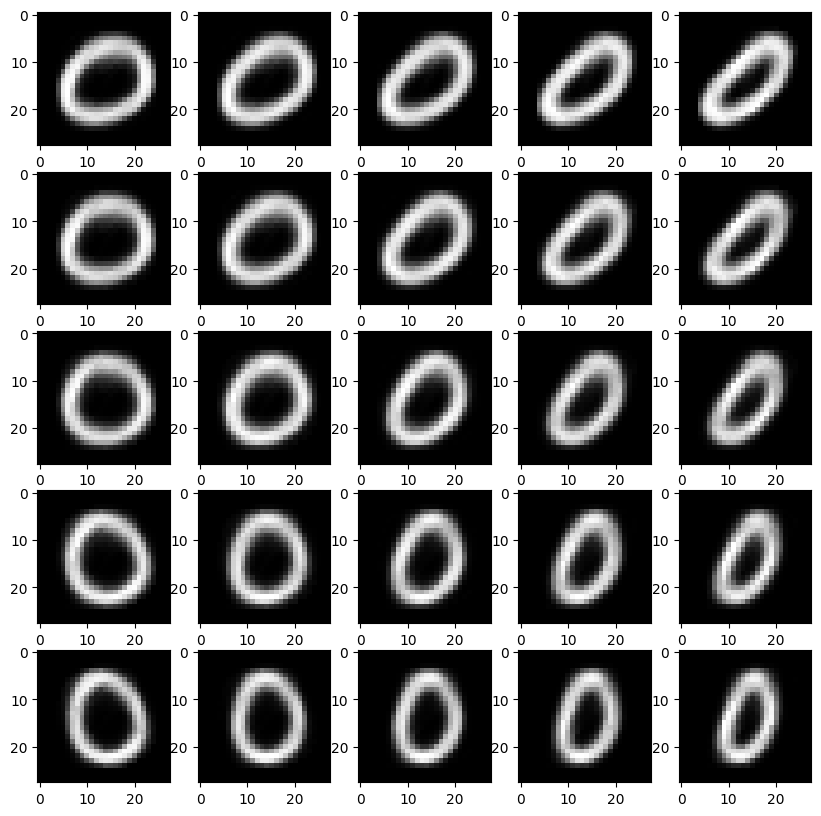

In [9]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [10]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
# z_mean, z_log_var, z = encoder.predict(data_test[0], batch_size=batch_size)
z_mean, z_log_var, z = encoder.predict(data_train[0], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

47/47 [==============================] - 0s 3ms/step
[[ 0.26609826 -0.2347422 ]
 [ 0.20446904 -0.40005705]
 [ 1.6288835   0.6510523 ]
 ...
 [ 1.0236353  -0.9518812 ]
 [ 1.2781556  -1.0255681 ]
 [ 0.8991008  -1.4972354 ]]
[[-2.9380987 -2.7402012]
 [-2.754321  -2.339721 ]
 [-2.2539544 -2.4073408]
 ...
 [-2.1396673 -1.9385469]
 [-2.3253803 -2.1871235]
 [-2.6076074 -1.9316865]]
[[ 0.2689535  -0.22744766]
 [ 0.17596415 -0.34254277]
 [ 1.6310455   0.6588035 ]
 ...
 [ 0.8071764  -0.9331984 ]
 [ 1.3193502  -1.0117496 ]
 [ 0.89070505 -1.5722044 ]]


/tmp/ipykernel_379/3272527471.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


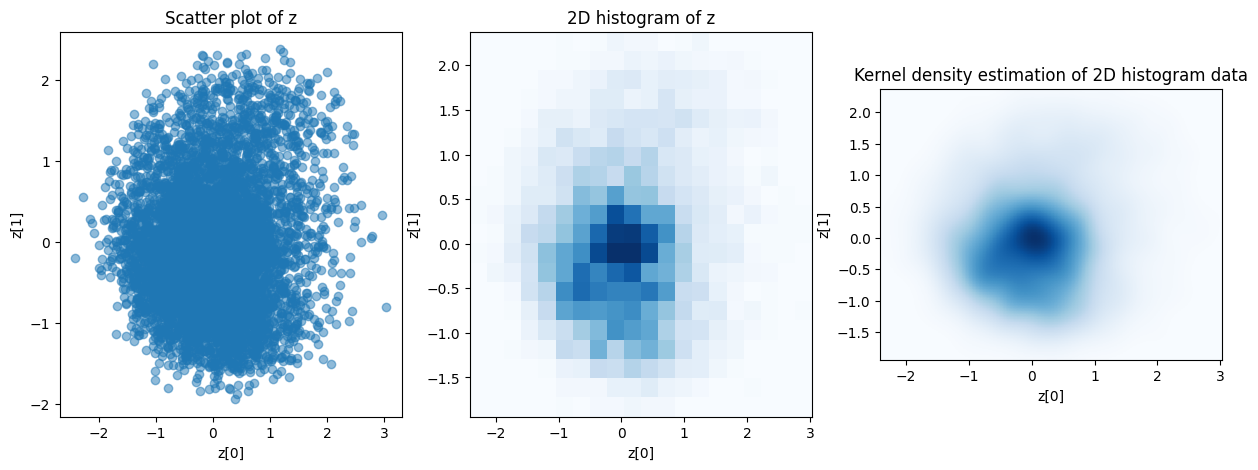

In [11]:
# x = z_mean[:, 0]
# y = z_mean[:, 1]
x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()


Epoch 1/10
53/53 [==============================] - 1s 14ms/step - loss: 25.0878 - val_loss: 15.8372
Epoch 2/10
53/53 [==============================] - 1s 12ms/step - loss: 13.9805 - val_loss: 12.5014
Epoch 3/10
53/53 [==============================] - 1s 13ms/step - loss: 12.2626 - val_loss: 11.6733
Epoch 4/10
53/53 [==============================] - 1s 13ms/step - loss: 11.6117 - val_loss: 11.1511
Epoch 5/10
53/53 [==============================] - 1s 12ms/step - loss: 11.2023 - val_loss: 10.6883
Epoch 6/10
53/53 [==============================] - 1s 13ms/step - loss: 10.9161 - val_loss: 10.6346
Epoch 7/10
53/53 [==============================] - 1s 13ms/step - loss: 10.8257 - val_loss: 10.3913
Epoch 8/10
53/53 [==============================] - 1s 13ms/step - loss: 10.6545 - val_loss: 10.3255
Epoch 9/10
53/53 [==============================] - 1s 11ms/step - loss: 10.5691 - val_loss: 10.1949
Epoch 10/10
1/1 [==============================] - 0s 15ms/step


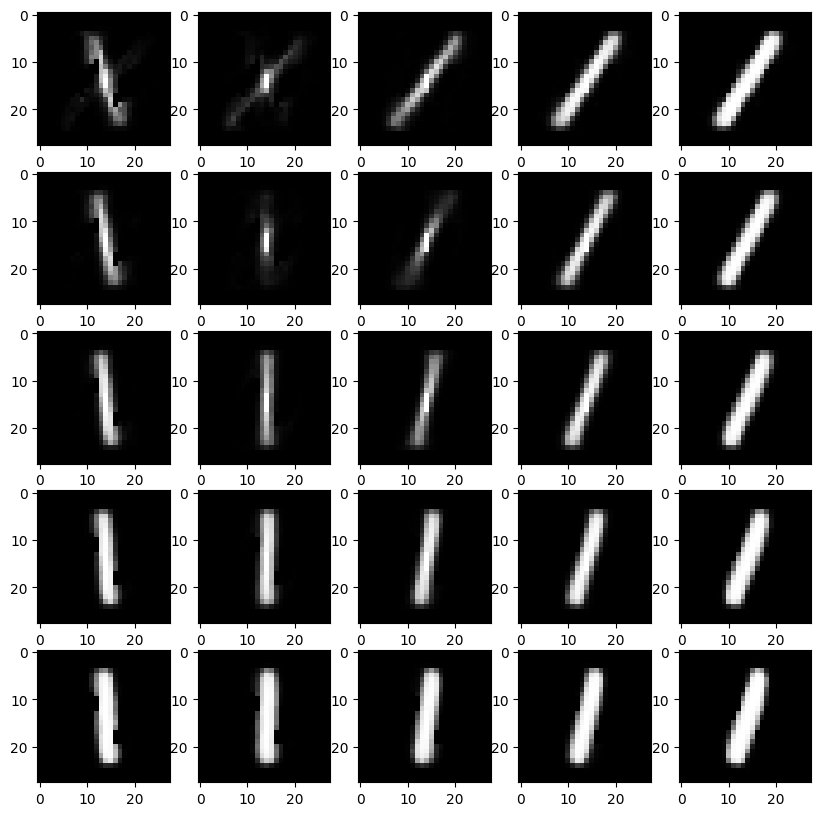

In [12]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[1],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[1], None))

x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

53/53 [==============================] - 0s 3ms/step
[[ 0.64838094 -0.79419583]
 [-1.3698665   0.47942582]
 [-0.8430022   0.04832079]
 ...
 [ 0.3773168  -0.6234444 ]
 [ 0.04848979 -1.431695  ]
 [ 0.09560109 -0.8509397 ]]
[[-2.2915647 -2.4041872]
 [-1.9929514 -1.7613403]
 [-2.376122  -2.2448194]
 ...
 [-2.5076065 -2.6079967]
 [-2.3998206 -2.2705216]
 [-2.5069995 -2.4004366]]
[[ 0.6538313  -0.7839882 ]
 [-1.4309014   0.5819823 ]
 [-0.84108883  0.0574399 ]
 ...
 [ 0.38249883 -0.6341584 ]
 [ 0.09722736 -1.4365718 ]
 [ 0.0867423  -0.8492484 ]]


/tmp/ipykernel_379/1839466173.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


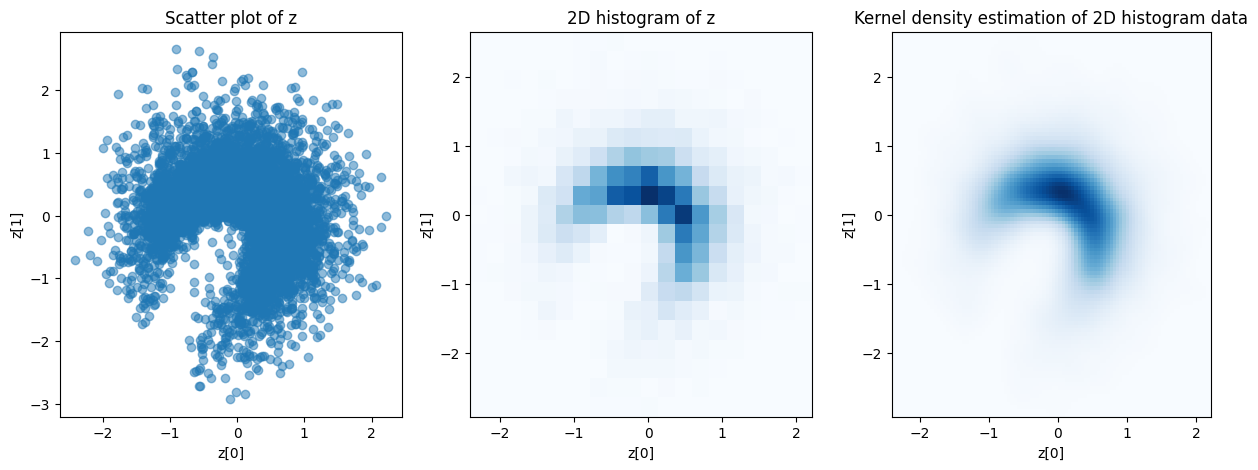

In [13]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[1], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [14]:
data_2class_train = np.concatenate(data_train[:2])
data_2class_test = np.concatenate(data_test[:2])
np.random.shuffle(data_2class_train)

# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_2class_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_2class_test, None))


Epoch 1/10
99/99 [==============================] - 1s 12ms/step - loss: 31.5238 - val_loss: 24.0379
Epoch 2/10
99/99 [==============================] - 1s 11ms/step - loss: 23.5917 - val_loss: 22.6920
Epoch 3/10
99/99 [==============================] - 1s 11ms/step - loss: 22.6163 - val_loss: 21.9749
Epoch 4/10
99/99 [==============================] - 1s 14ms/step - loss: 22.1155 - val_loss: 21.5849
Epoch 5/10
99/99 [==============================] - 1s 12ms/step - loss: 21.7621 - val_loss: 21.4280
Epoch 6/10
99/99 [==============================] - 1s 12ms/step - loss: 21.4843 - val_loss: 21.0395
Epoch 7/10
99/99 [==============================] - 1s 11ms/step - loss: 21.1581 - val_loss: 20.7372
Epoch 8/10
99/99 [==============================] - 1s 11ms/step - loss: 20.9041 - val_loss: 20.5406
Epoch 9/10
99/99 [==============================] - 1s 11ms/step - loss: 20.6531 - val_loss: 20.3078
Epoch 10/10
99/99 [==============================] - 1s 11ms/step - loss: 20.4837 - val_los

1/1 [==============================] - 0s 15ms/step


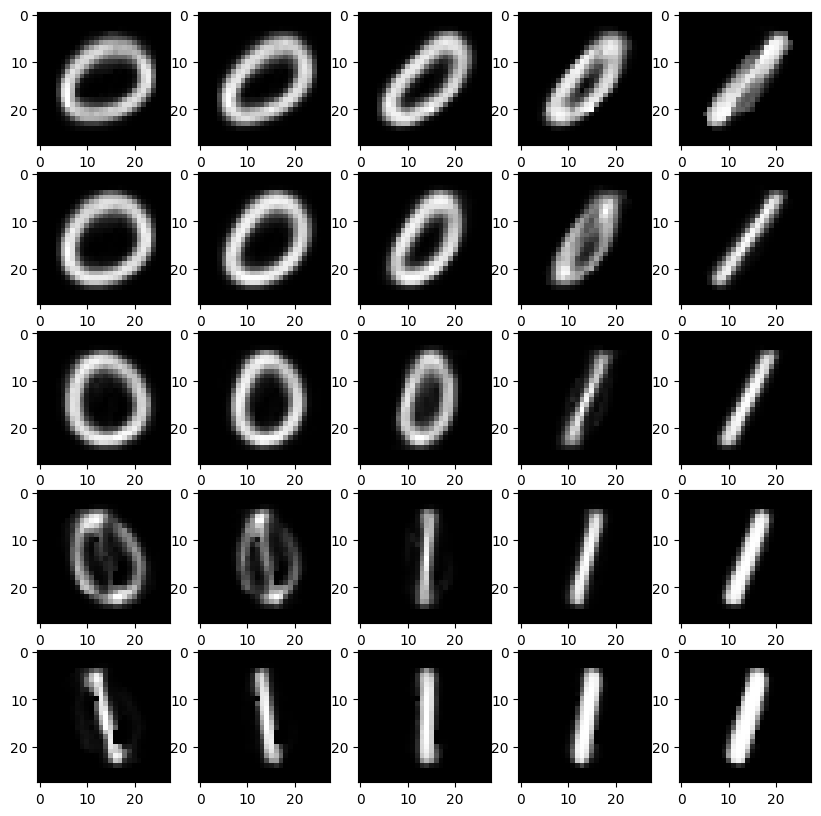

In [15]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

99/99 [==============================] - 0s 3ms/step
[[-0.19026095 -0.61895674]
 [-0.2823034  -0.7089784 ]
 [ 0.1962071  -0.44228798]
 ...
 [ 0.9658858  -0.16548476]
 [ 1.1856612  -0.6442739 ]
 [ 0.8167429  -0.2866441 ]]
[[-3.1966488 -2.907879 ]
 [-2.9712353 -2.7033587]
 [-3.777725  -3.4600987]
 ...
 [-2.6049707 -2.9194446]
 [-2.7577202 -3.243506 ]
 [-2.8737323 -3.1402993]]
[[-0.18805622 -0.6127883 ]
 [-0.3052498  -0.66899776]
 [ 0.19667818 -0.439583  ]
 ...
 [ 1.0320792  -0.14051874]
 [ 1.1465155  -0.7721768 ]
 [ 0.80991524 -0.27532893]]


/tmp/ipykernel_379/1345161528.py:22: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


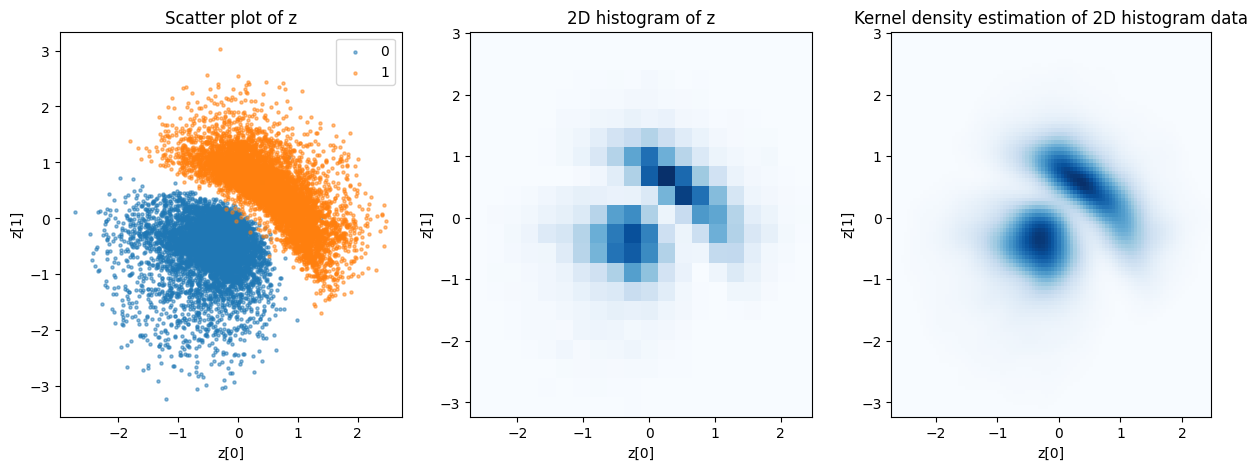

In [16]:
data_2class_train = np.concatenate(data_train[:2])
label_2class_train = np.concatenate([np.zeros(len(data_train[0])), np.ones(len(data_train[1]))])

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==0], y[label_2class_train==0], alpha=0.5, label='0', s=5)
axs[0].scatter(x[label_2class_train==1], y[label_2class_train==1], alpha=0.5, label='1', s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [17]:
class1 = 1
class2 = 7

data_2class_train = np.concatenate([data_train[class1], data_train[class2]])
label_2class_train = np.concatenate([np.ones(len(data_train[class1]))*class1, np.ones(len(data_train[class2]))*class2])

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
kernel1 = kde.gaussian_kde(values1)
f1 = np.reshape(kernel1(positions).T, xx.shape)

values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
kernel2 = kde.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions).T, xx.shape)


102/102 [==============================] - 0s 2ms/step
[[ 1.2468613  -0.20920469]
 [-0.5092553   1.4837704 ]
 [-0.30412182  0.90189517]
 ...
 [ 0.47409242 -0.70688677]
 [ 0.2151243  -0.10481504]
 [ 0.34923723 -1.326908  ]]
[[-2.4252205 -2.7885458]
 [-2.331649  -2.1046493]
 [-2.7516968 -2.566586 ]
 ...
 [-2.2951632 -2.2497334]
 [-3.0384238 -2.8739882]
 [-2.2630353 -1.6795144]]
[[ 1.3295133  -0.12316782]
 [-0.3618022   1.5396833 ]
 [-0.25383422  0.9609778 ]
 ...
 [ 0.56822246 -0.42496487]
 [ 0.16254936 -0.14025143]
 [ 0.3392551  -1.4041011 ]]


/tmp/ipykernel_379/1940600678.py:25: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel1 = kde.gaussian_kde(values1)
/tmp/ipykernel_379/1940600678.py:29: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel2 = kde.gaussian_kde(values2)


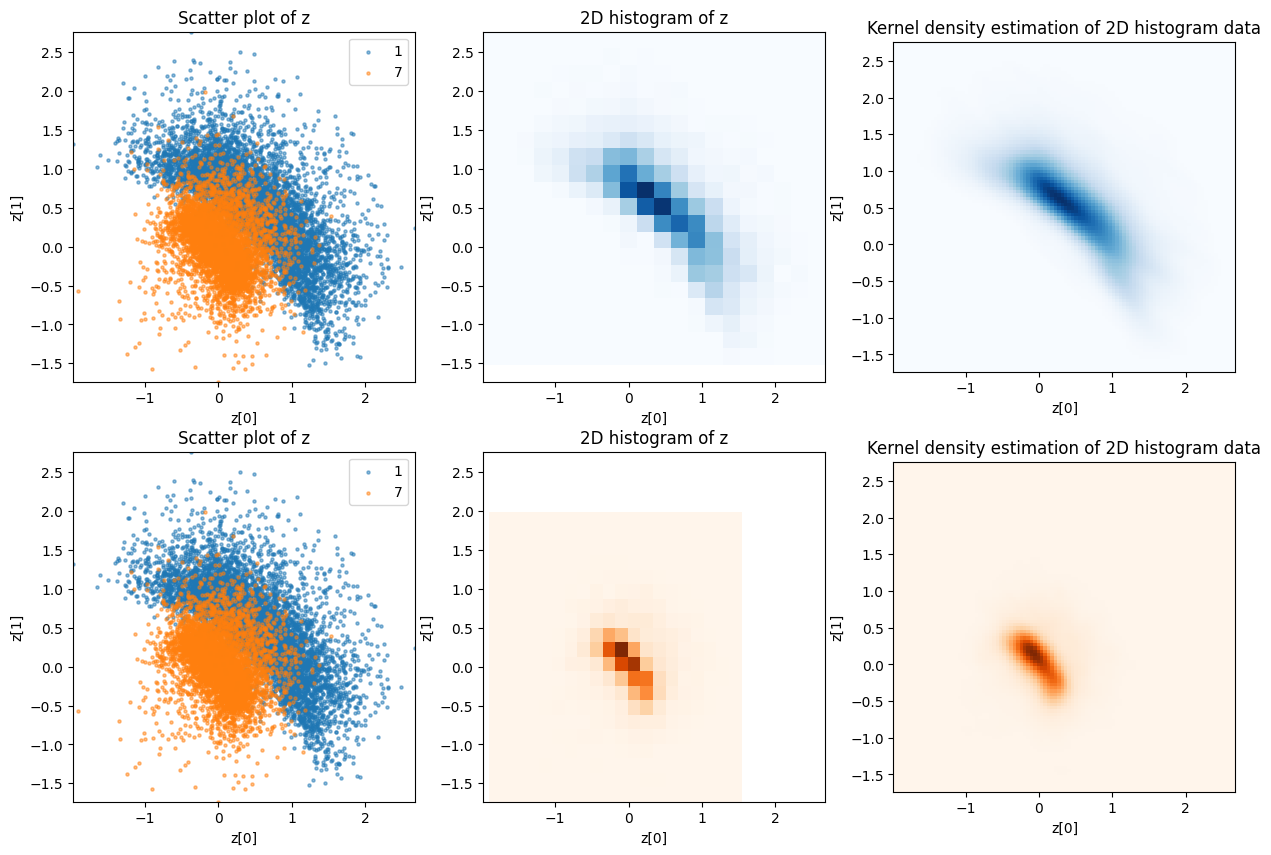

In [18]:
# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0][0].legend()
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title("Scatter plot of z")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[1][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[1][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[1][0].legend()
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Scatter plot of z")
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])


axs[0][1].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title("2D histogram of z")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[1][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title("2D histogram of z")
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])

axs[0][2].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[0][2].plot(x, y, 'k.', markersize=2)
axs[0][2].set_xlim([xmin, xmax])
axs[0][2].set_ylim([ymin, ymax])
axs[0][2].set_xlabel("z[0]")
axs[0][2].set_ylabel("z[1]")
axs[0][2].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][2].plot(x, y, 'k.', markersize=2)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [19]:
cls_ood = 0

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[cls_ood], batch_size=batch_size)

x_ood = z[:, 0]
y_ood = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
values_ood = np.vstack([x_ood, y_ood])
kernel_ood = kde.gaussian_kde(values_ood)
f_ood = np.reshape(kernel_ood(positions).T, xx.shape)

47/47 [==============================] - 0s 3ms/step


/tmp/ipykernel_379/253192480.py:11: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel_ood = kde.gaussian_kde(values_ood)


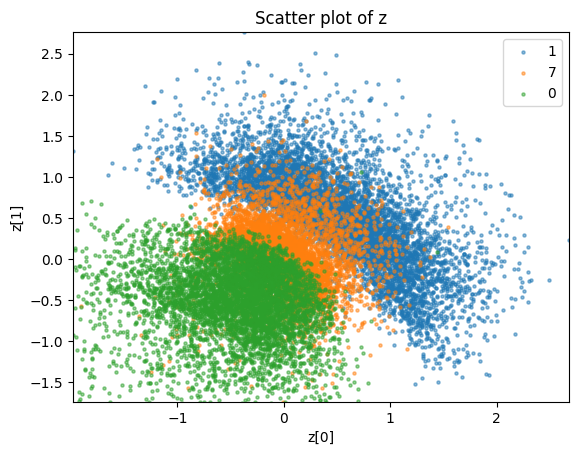

In [20]:
plt.scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
plt.scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
plt.scatter(x_ood, y_ood, alpha=0.5, label=cls_ood, s=5)
plt.legend()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Scatter plot of z")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

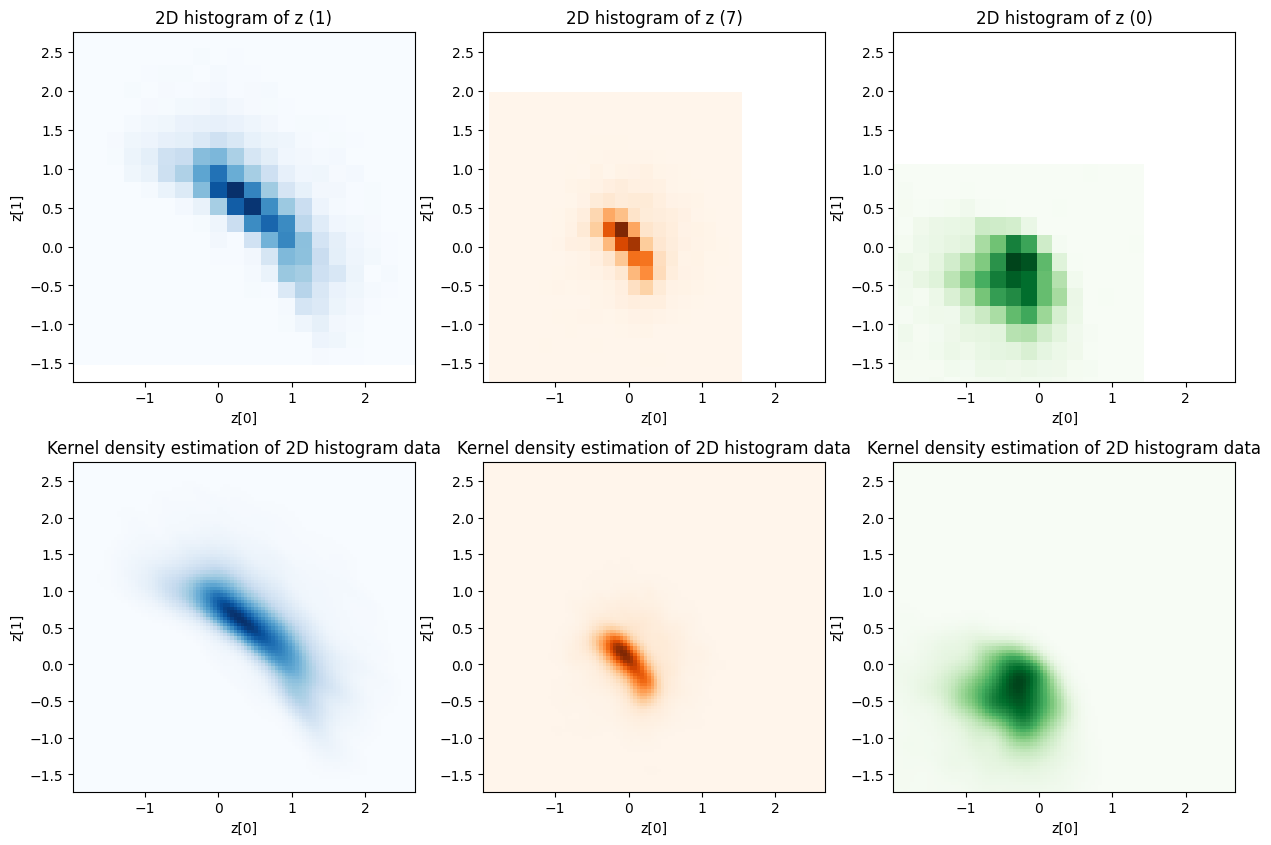

In [21]:
# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title(f"2D histogram of z ({class1})")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[0][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title(f"2D histogram of z ({class2})")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[0][2].hist2d(x_ood, y_ood, bins=20, cmap='Greens')
axs[0][2].set_xlabel("z[0]")
axs[0][2].set_ylabel("z[1]")
axs[0][2].set_title(f"2D histogram of z ({cls_ood})")
axs[0][2].set_xlim([xmin, xmax])
axs[0][2].set_ylim([ymin, ymax])

axs[1][0].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Kernel density estimation of 2D histogram data")

axs[1][1].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f_ood), cmap='Greens', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [22]:
# モデルのパラメータを初期化する
K.clear_session()

# モデルを定義する
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# モデルをコンパイルする
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_mlp.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# モデルをトレーニングする
label_t = np.zeros(label_2class_train.shape)
label_t[label_2class_train == class1] = 0
label_t[label_2class_train == class2] = 1
model_mlp.fit(data_2class_train, label_t, epochs=10)


Epoch 1/10
407/407 [==============================] - 4s 7ms/step - loss: 0.3251 - accuracy: 0.9906
Epoch 2/10
407/407 [==============================] - 3s 7ms/step - loss: 0.2429 - accuracy: 0.9955
Epoch 3/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1853 - accuracy: 0.9957
Epoch 4/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1442 - accuracy: 0.9965
Epoch 5/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1147 - accuracy: 0.9968
Epoch 6/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0919 - accuracy: 0.9972
Epoch 7/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0732 - accuracy: 0.9978
Epoch 8/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0604 - accuracy: 0.9981
Epoch 9/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0499 - accuracy: 0.9985
Epoch 10/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0418 - accuracy: 0.9982

In [23]:

# モデルを評価する
index_c1 = y_test==class1
index_c2 = y_test==class2
data_t = np.concatenate([x_test[index_c1], x_test[index_c2]])
label_t = np.concatenate([np.zeros(len(x_test[index_c1])), np.ones(len(x_test[index_c2]))])
test_loss, test_acc = model_mlp.evaluate(data_t, label_t)

# 結果を出力する
print(f'テスト用データに対する損失: {test_loss:.4f}')
print(f'テスト用データに対する精度: {test_acc:.4f}')

68/68 [==============================] - 0s 5ms/step - loss: 0.0522 - accuracy: 0.9931
テスト用データに対する損失: 0.0522
テスト用データに対する精度: 0.9931


In [24]:
intermediate_layer_model = tf.keras.models.Model(inputs=model_mlp.input,
                                                    outputs=model_mlp.layers[-2].output)
intermediate_output = intermediate_layer_model.predict(data_2class_train)

407/407 [==============================] - 1s 2ms/step


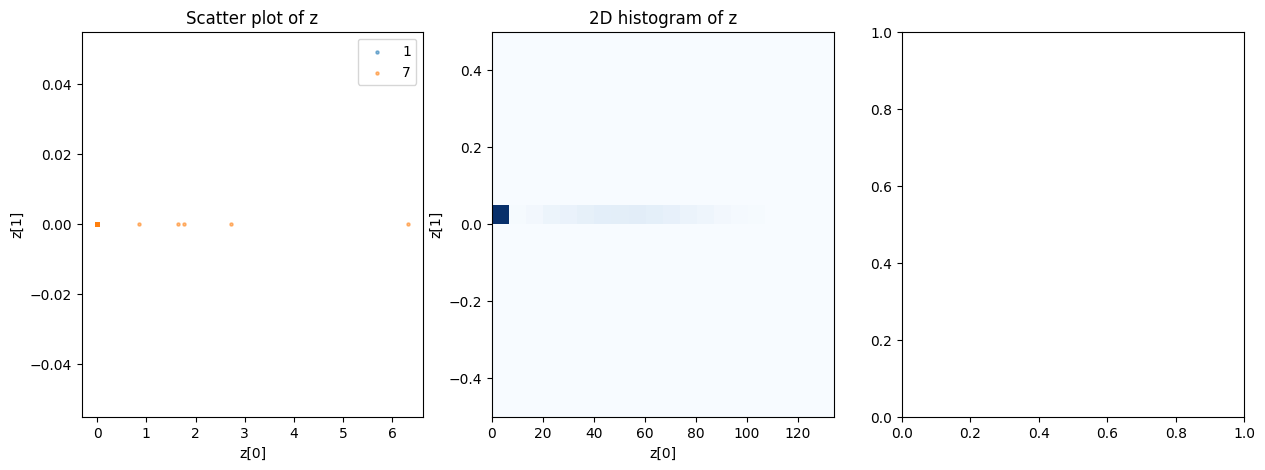

In [25]:
x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
# kernel1 = kde.gaussian_kde(values1)
# f1 = np.reshape(kernel1(positions).T, xx.shape)

# values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
# kernel2 = kde.gaussian_kde(values2)
# f2 = np.reshape(kernel2(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==0], y[label_2class_train==0], alpha=0.5, label=class1, s=5)
axs[0].scatter(x[label_2class_train==1], y[label_2class_train==1], alpha=0.5, label=class2, s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

# axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# # axs[2].plot(x, y, 'k.', markersize=2)
# axs[2].set_xlim([xmin, xmax])
# axs[2].set_ylim([ymin, ymax])
# axs[2].set_xlabel("z[0]")
# axs[2].set_ylabel("z[1]")
# axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

2クラス分類が1次元で事足りてしまっているので、ヒストグラムデータの共分散行列が特異行列になり（逆行列が存在しない）KDEが動かなかった。

In [26]:
intermediate_output = intermediate_layer_model.predict(data_train[cls_ood])

186/186 [==============================] - 0s 2ms/step


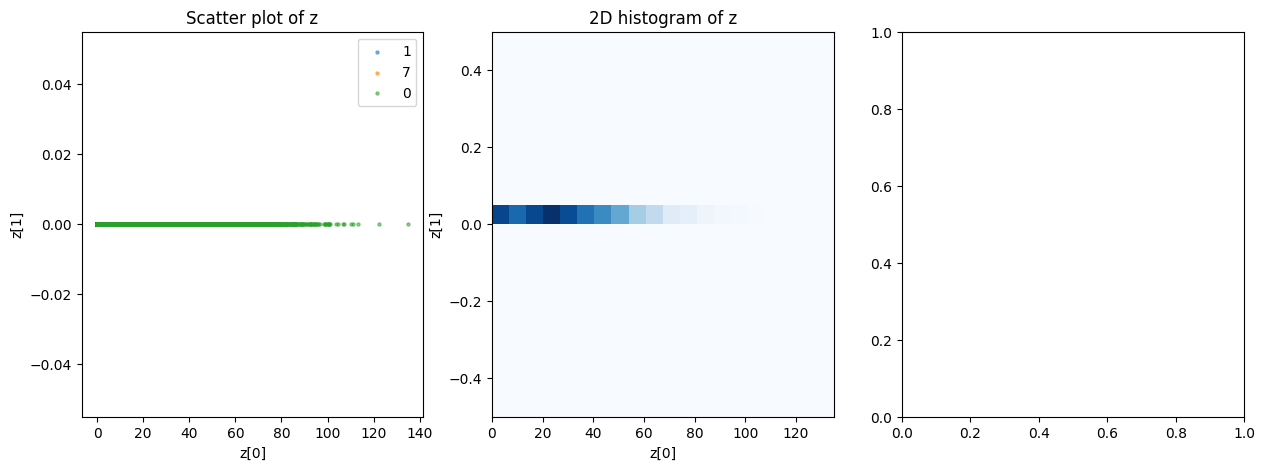

In [27]:
x_ood = intermediate_output[:, 0]
y_ood = intermediate_output[:, 1]

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==0], y[label_2class_train==0], alpha=0.5, label=class1, s=5)
axs[0].scatter(x[label_2class_train==1], y[label_2class_train==1], alpha=0.5, label=class2, s=5)
axs[0].scatter(x_ood, y_ood, alpha=0.5, label=cls_ood, s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x_ood, y_ood, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

plt.show()

In [28]:
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist

# データセットの読み込み
(x_train, _), (x_test, _) = mnist.load_data()

# データの前処理
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# オートエンコーダの定義
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(input_img)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(encoded)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoded = tf.keras.layers.Reshape((28, 28, 1))(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# オートエンコーダの学習
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

# テストデータでのオートエンコーダの性能評価
decoded_imgs = autoencoder.predict(x_test)



2023-11-26 11:17:56.437095: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-26 11:17:56.905944: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-26 11:17:57.462666: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-26 11:17:57.542361: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 0.0667 - val_loss: 0.0546
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0488 - val_loss: 0.0450
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0436 - val_loss: 0.0423
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0416 - val_loss: 0.0411
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0406 - val_loss: 0.0405
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0398 - val_loss: 0.0396
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0392 - val_loss: 0.0393
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0387 - val_loss: 0.0388
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0384 - val_loss: 0.0386
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


1/1 [==============================] - 0s 21ms/step


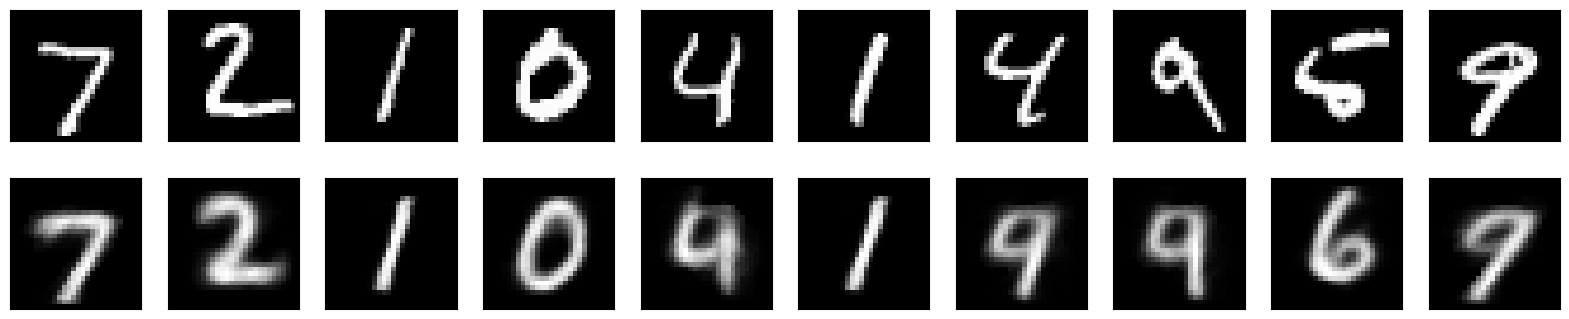

In [29]:
# テストデータの再構成画像を表示
n = 10  # 表示する画像の数
plt.figure(figsize=(20, 4))
for i in range(n):
    # テストデータを入力し、再構成画像を生成
    reconstructed_img = autoencoder.predict(x_test[i].reshape(1, 28, 28, 1))

    # 元の画像を表示
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 再構成された画像を表示
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()